In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+5a2c637', 'torch:', '1.0.0.dev20181029', 'cuda:', True)


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 2

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K
NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
RESTORE = False
PATH_ENC = "weights/baseline_2shots-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

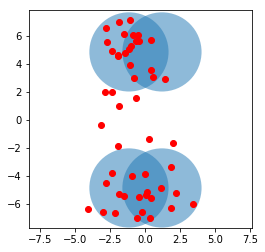

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [5]:
def initialize():
    enc_trans = Encoder()
    optimizer =  torch.optim.Adam(list(enc_trans.parameters()),lr=LEARNING_RATE)    
    return enc_trans, optimizer

enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    eubo, kl, ess, variational, elbo = oneshot_givenZ(enc, alpha_trans_0, Pi, mu_ks, cov_ks, A_true, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ELBOs.append(elbo.item())
    ESSs.append(ess)
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f, KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

# if RESTORE:
#     enc.load_state_dict(torch.load(PATH_ENC))
# else:
#     torch.save(enc.state_dict(), PATH_ENC)
#     save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -245.716003, elbo : -279.731140, KL : 53.593418 (3s)
epoch : 1, eubo : -260.563416, elbo : -277.712646, KL : 49.273766 (3s)
epoch : 2, eubo : -277.012726, elbo : -295.193115, KL : 48.782372 (3s)
epoch : 3, eubo : -272.438599, elbo : -294.518768, KL : 53.608795 (4s)
epoch : 4, eubo : -262.712555, elbo : -272.738739, KL : 53.792648 (4s)
epoch : 5, eubo : -234.506119, elbo : -255.270950, KL : 44.284012 (4s)
epoch : 6, eubo : -261.446198, elbo : -278.243286, KL : 55.788857 (4s)
epoch : 7, eubo : -216.978973, elbo : -229.552063, KL : 41.697163 (4s)
epoch : 8, eubo : -238.307205, elbo : -255.819595, KL : 41.188805 (4s)
epoch : 9, eubo : -254.934906, elbo : -275.127350, KL : 51.843712 (4s)
epoch : 10, eubo : -279.416077, elbo : -294.928528, KL : 51.671108 (4s)
epoch : 11, eubo : -247.153183, elbo : -260.185028, KL : 56.780987 (4s)
epoch : 12, eubo : -214.949158, elbo : -230.121384, KL : 43.175053 (3s)
epoch : 13, eubo : -256.338654, elbo : -275.862823, KL : 45.885033 (4s)
ep

In [7]:
# plot_dirs(variational, alpha_trans_0, Z_true, T, K, vmax=15)

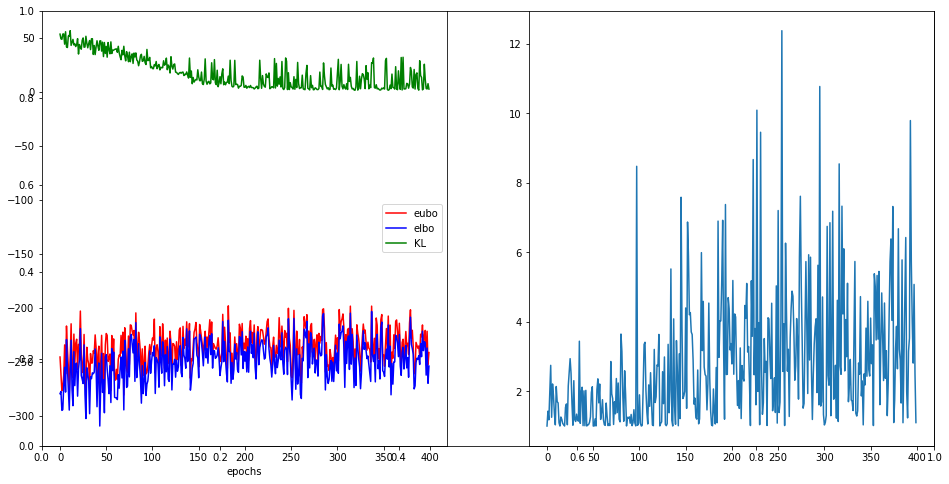

In [10]:
def plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax1 = fig.add_subplot(1,2,1)
    x = np.arange(len(EUBOs))
    ax1.plot(EUBOs, 'r-', label='eubo')
    ax1.plot(ELBOs, 'b-', label='elbo')
    ax1.plot(KLs, 'g-', label='KL')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(np.array(ESSs))
    fig.savefig(PATH_ENC + 'results.png')

plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [18]:
init_v = init_velocity(dt)
T = np.random.randint(T_min, T_max)
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)



In [19]:
Zs, log_weights, log_normalizer = smc_hmm(Pi, A_true, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_ret = resampling_smc(Zs, log_weights)
Z_pairwise = torch.cat((Z_ret[:-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)
variational, A_sample = enc(Z_pairwise, alpha_trans_0)

Zs, log_weights, log_normalizer = smc_hmm(Pi, A_sample, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_ret = resampling_smc(Zs, log_weights)

In [20]:
np.around(torch.cat((Z_ret, Y), -1).data.numpy(), 2)

array([[ 0.  ,  1.  ,  0.  ,  0.  ,  2.92, -3.33],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  3.82, -1.5 ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  7.48, -4.14],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  1.61, -2.59],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  5.38, -1.97],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  6.31, -0.95],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  3.98,  0.14],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  4.47, -1.52],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  4.11, -2.13],
       [ 0.  ,  0.  ,  1.  ,  0.  , -2.01, -0.93],
       [ 0.  ,  0.  ,  1.  ,  0.  , -5.21, -2.72],
       [ 0.  ,  0.  ,  1.  ,  0.  , -5.25, -0.9 ],
       [ 0.  ,  0.  ,  1.  ,  0.  , -5.79, -0.02],
       [ 0.  ,  0.  ,  0.  ,  1.  , -4.47,  1.05],
       [ 0.  ,  0.  ,  0.  ,  1.  , -3.09,  2.02],
       [ 0.  ,  0.  ,  0.  ,  1.  , -3.4 ,  1.42],
       [ 0.  ,  0.  ,  0.  ,  1.  , -4.59, -0.33],
       [ 0.  ,  0.  ,  0.  ,  1.  , -4.83,  0.95],
       [ 0.  ,  0.  ,  0.  ,  1.  , -4.75, -0.01],
       [ 0.  ,  0.  ,  0.  ,  1

In [21]:
A_sample

tensor([[0.6090, 0.1558, 0.0208, 0.2143],
        [0.1087, 0.7131, 0.1608, 0.0174],
        [0.1426, 0.0995, 0.6074, 0.1505],
        [0.2303, 0.0405, 0.0571, 0.6721]])

In [22]:
A_true

tensor([[9.4737e-01, 5.2632e-08, 5.2632e-08, 5.2632e-02],
        [1.1111e-07, 8.8889e-01, 1.1111e-01, 1.1111e-07],
        [3.3333e-07, 3.3333e-07, 6.6667e-01, 3.3333e-01],
        [9.5238e-02, 4.7619e-08, 4.7619e-08, 9.0476e-01]])